In [32]:
import tensorflow as tf
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import data

- The idea was to find two seeds:
one that can produce such random gaussian 2D dataset which Logistic Regression <b>cannot separate linearly</b> into classes, and another seed that <b>can produce linearly separable</b> dataset

In [33]:
SEED = 100
NUM_EXAMPLES = 50
CLASSES = 3
DISTRIBUTIONS = 6

In [34]:
class TFLogreg:
    
    """
        Class that represents a tensorflow implementation of Logistic Regression model.
    """

    def __init__(self, D, C, param_delta=0.1, param_lambda=0.01):
        """Arguments:
           - D: dimensions of each datapoint
           - C: number of classes
           - param_delta: training step
           - param_lambda= regularization strength
        """
        self.X = tf.placeholder(dtype=tf.float32, shape=[None, D])
        self.Yoh_ = tf.placeholder(dtype=tf.float32, shape=[None, C])
        self.W = tf.Variable(initial_value=tf.random_normal([D, C]))
        self.b = tf.Variable(initial_value=tf.random_normal([1, C]))

        self.probs = tf.nn.softmax(tf.matmul(self.X, self.W) + self.b)

        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.Yoh_ * tf.log(self.probs), reduction_indices=[1]))
        self.regularization = param_lambda * tf.nn.l2_loss(self.W)
        self.loss = self.cross_entropy + self.regularization

        self.train_step = tf.train.GradientDescentOptimizer(param_delta).minimize(self.loss)
        
        self.session = tf.InteractiveSession()

    def train(self, X, Yoh_, param_niter):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        self.session.run(tf.initialize_all_variables())

        for i in range(param_niter+1):
            tr, loss = self.session.run([self.train_step, self.loss], feed_dict={self.X: X, self.Yoh_: Yoh_})
            if i % 1000 == 0:
                print("{0:4}. Loss: {1:.8f}".format(i, loss))

    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        probs = self.session.run(self.probs, feed_dict={self.X: X})
        return probs

    def classify(self, X):
        return np.argmax(self.eval(X), axis=1)

    def eval_perf(self, Y, Y_):
        # needed to compute scores of our model
        # 'weighted' takes into consideration labels imbalance
        if max(int(max(Y_) + 1), int(max(Y) + 1)) == 2:
            average = 'binary'
        else:
            average = 'weighted'

        accuracy = accuracy_score(Y_, Y)
        precision = precision_score(Y_, Y, average=average)
        recall = recall_score(Y_, Y, average=average)
        f1 = f1_score(Y_, Y, average=average)

        print("Accuracy: {0:.3f}\n"
              "Precision: {1:.3f}\n"
              "Recall: {2:.3f}\n"
              "F1: {3:.3f} ".format(accuracy, precision, recall, f1))

In [35]:
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [36]:
X, Y_ = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

- We are working with one hotted vectors of labels
- for example:

    Y :
        [2, 0, 1]
    
    Yoh_ :
        [0, 0, 1]
        [1, 0, 0] 
        [0, 1, 0]

In [37]:
Yoh_ = Y_.reshape(-1)
Yoh_ = np.eye(CLASSES)[Yoh_]

In [38]:
tflr = TFLogreg(X.shape[1], Yoh_.shape[1], param_delta=0.01, param_lambda=0.01)

In [39]:
tflr.train(X, Yoh_, 50000)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
   0. Loss: 11.25698566
1000. Loss: 1.01093400
2000. Loss: 0.98401630
3000. Loss: 0.97285116
4000. Loss: 0.96751016
5000. Loss: 0.96466035
6000. Loss: 0.96299678
7000. Loss: 0.96194851
8000. Loss: 0.96124405
9000. Loss: 0.96074498
10000. Loss: 0.96037692
11000. Loss: 0.96009666
12000. Loss: 0.95987833
13000. Loss: 0.95970577
14000. Loss: 0.95956773
15000. Loss: 0.95945662
16000. Loss: 0.95936650
17000. Loss: 0.95929331
18000. Loss: 0.95923370
19000. Loss: 0.95918500
20000. Loss: 0.95914531
21000. Loss: 0.95911270
22000. Loss: 0.95908606
23000. Loss: 0.95906442
24000. Loss: 0.95904654
25000. Loss: 0.95903206
26000. Loss: 0.95902008
27000. Loss: 0.95901036
28000. Loss: 0.95900238
29000. Loss: 0.95899582
30000. Loss: 0.95899045
31000. Loss: 0.95898604
32000. Loss: 0.95898247
33000. Loss: 0.95897955
34000. Loss: 0.95897704
35000. Loss: 0.95897514
36000. Loss: 0.95897353
37000. Loss: 0.95897222
38000. Loss: 0.95897114

- We can see the insecurity model has due to having a linearly unseparable dataset by looking at probabilities

In [40]:
probs = tflr.eval(X)
probs

array([[ 0.13097228,  0.46477461,  0.40425315],
       [ 0.2598978 ,  0.34450281,  0.39559934],
       [ 0.24776211,  0.36076227,  0.39147568],
       [ 0.20003334,  0.40023711,  0.39972958],
       [ 0.28768003,  0.32843539,  0.38388461],
       [ 0.19961762,  0.38823143,  0.41215092],
       [ 0.36012143,  0.28352058,  0.35635802],
       [ 0.16893731,  0.41896242,  0.41210029],
       [ 0.12069064,  0.46025193,  0.4190574 ],
       [ 0.3900423 ,  0.25821024,  0.35174748],
       [ 0.29791331,  0.31859228,  0.38349441],
       [ 0.23624603,  0.36296383,  0.40079021],
       [ 0.11346558,  0.46791965,  0.4186148 ],
       [ 0.37931034,  0.27004051,  0.35064915],
       [ 0.49760494,  0.20553309,  0.29686201],
       [ 0.38431671,  0.26392549,  0.35175779],
       [ 0.34420368,  0.28769329,  0.36810303],
       [ 0.24742457,  0.35923371,  0.39334178],
       [ 0.3853249 ,  0.26939419,  0.34528092],
       [ 0.24007866,  0.35890788,  0.4010134 ],
       [ 0.3571811 ,  0.28254932,  0.360

In [41]:
tflr.eval_perf(np.argmax(probs, axis=1), np.argmax(Yoh_, axis=1))

Accuracy: 0.403
Precision: 0.335
Recall: 0.403
F1: 0.366 


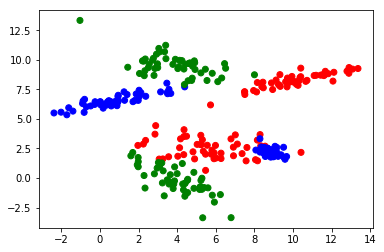

In [42]:
colors = ['red', 'green', 'blue']
plt.scatter(X[:, 0], X[:, 1], c=Y_.flatten(), cmap=ListedColormap(colors))
plt.show()

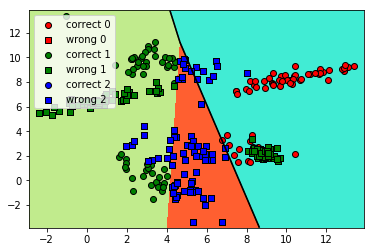

In [43]:
data.plot_decision_boundary(X, lambda x: tflr.classify(x))
# graph the data points
data.graph_data(X, Y_, np.argmax(probs, axis=1))

In [44]:
SEED = 125
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [45]:
X2, Y_2 = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

In [46]:
Yoh_2 = Y_2.reshape(-1)
Yoh_2 = np.eye(CLASSES)[Yoh_2]

In [47]:
tflr2 = TFLogreg(X2.shape[1], Yoh_2.shape[1], param_delta=0.01, param_lambda=0.01)

In [48]:
tflr2.train(X2, Yoh_2, 50000)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
   0. Loss: 10.23495960
1000. Loss: 0.45281634
2000. Loss: 0.43041617
3000. Loss: 0.41278026
4000. Loss: 0.39837182
5000. Loss: 0.38627756
6000. Loss: 0.37591767
7000. Loss: 0.36690533
8000. Loss: 0.35897031
9000. Loss: 0.35191664
10000. Loss: 0.34559721
11000. Loss: 0.33989888
12000. Loss: 0.33473206
13000. Loss: 0.33002487
14000. Loss: 0.32571864
15000. Loss: 0.32176462
16000. Loss: 0.31812194
17000. Loss: 0.31475610
18000. Loss: 0.31163761
19000. Loss: 0.30874097
20000. Loss: 0.30604440
21000. Loss: 0.30352861
22000. Loss: 0.30117691
23000. Loss: 0.29897457
24000. Loss: 0.29690832
25000. Loss: 0.29496694
26000. Loss: 0.29313987
27000. Loss: 0.29141802
28000. Loss: 0.28979304
29000. Loss: 0.28825760
30000. Loss: 0.28680491
31000. Loss: 0.28542891
32000. Loss: 0.28412420
33000. Loss: 0.28288585
34000. Loss: 0.28170940
35000. Loss: 0.28059033
36000. Loss: 0.27952492
37000. Loss: 0.27850991
38000. Loss: 0.27754202

In [49]:
probs2 = tflr2.eval(X2)

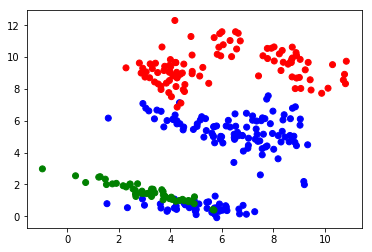

In [50]:
plt.scatter(X2[:, 0], X2[:, 1], c=Y_2.flatten(), cmap=ListedColormap(colors))
plt.show()

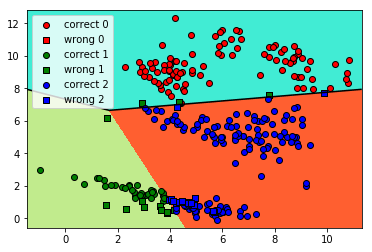

In [51]:
data.plot_decision_boundary(X2, lambda x: tflr2.classify(x))
# graph the data points
data.graph_data(X2, Y_2, np.argmax(probs2, axis=1))

In [52]:
tflr2.eval_perf(np.argmax(probs2, axis=1), np.argmax(Yoh_2, axis=1))

Accuracy: 0.900
Precision: 0.898
Recall: 0.900
F1: 0.899 
